In [1]:
import pickle 
import torch
import torch.nn as nn
import numpy as np
import sys
import random
import optuna
sys.path.append('../..')
sys.path.append('../../ml_mmrf/')
from data import load_mmrf
sys.path.append('../../../ief_core/')
sys.path.append('../../../ief_core/models/')
from ssm.ssm_dummy import SSM, SSMAtt
from utils import *
from torch.utils.data import DataLoader, TensorDataset
from numpy.random import choice 

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns

## alternate font/graph format
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rc('font', weight='heavy')
plt.rc('xtick', labelsize='x-large')
plt.rc('ytick', labelsize='x-large')
plt.rc('axes', labelsize='x-large')

In [3]:
fold = 1
ddata = load_mmrf(fold_span = [fold], \
                              digitize_K = 0, \
                              digitize_method = 'uniform', \
                              suffix='_2mos_tr', \
                              restrict_markers=False, \
                              add_syn_marker=True, \
                              window='first_second', \
                              data_aug=False)
print(ddata.keys())

loading from: /afs/csail.mit.edu/u/z/zeshanmh/research/ief/data/ml_mmrf/ml_mmrf_v1/cleaned_mm_fold_2mos_tr.pkl
adding synthetic marker in fold 1, set train...
new shape of X: (143, 33, 18)
new shape of M: (143, 33, 18)
adding synthetic marker in fold 1, set valid...
new shape of X: (63, 33, 18)
new shape of M: (63, 33, 18)
adding synthetic marker in fold 1, set test...
new shape of X: (89, 33, 18)
new shape of M: (89, 33, 18)
{'MMRF_1060', 'MMRF_1030', 'MMRF_1951'}
dict_keys([1])


In [6]:
X = ddata[1]['train']['x']
M = ddata[1]['train']['m']
A = ddata[1]['train']['a']
Y = ddata[1]['train']['ys_seq']
print(ddata[1]['train']['feature_names_x'])
print(X.shape)
pd_idxs = np.where(Y==1)[0]
nonpd_idxs = np.where(Y==0)[0]
print(len(pd_idxs))
print(len(nonpd_idxs))
print(A[1,:,-2])
xfeats = ddata[1]['train']['feature_names_x'].tolist()
midx = xfeats.index('serum_m_protein')
klidx= xfeats.index('kl_ratio')
smidx= xfeats.index('syn_marker')
print(midx)
print(ddata[1]['train']['pids'][131])

['cbc_abs_neut' 'chem_albumin' 'chem_bun' 'chem_calcium' 'chem_creatinine'
 'chem_glucose' 'cbc_hemoglobin' 'serum_kappa' 'serum_m_protein'
 'cbc_platelet' 'chem_totprot' 'cbc_wbc' 'serum_iga' 'serum_igg'
 'serum_igm' 'serum_lambda' 'kl_ratio' 'syn_marker']
(143, 33, 18)
24
119
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
8
MMRF_1146


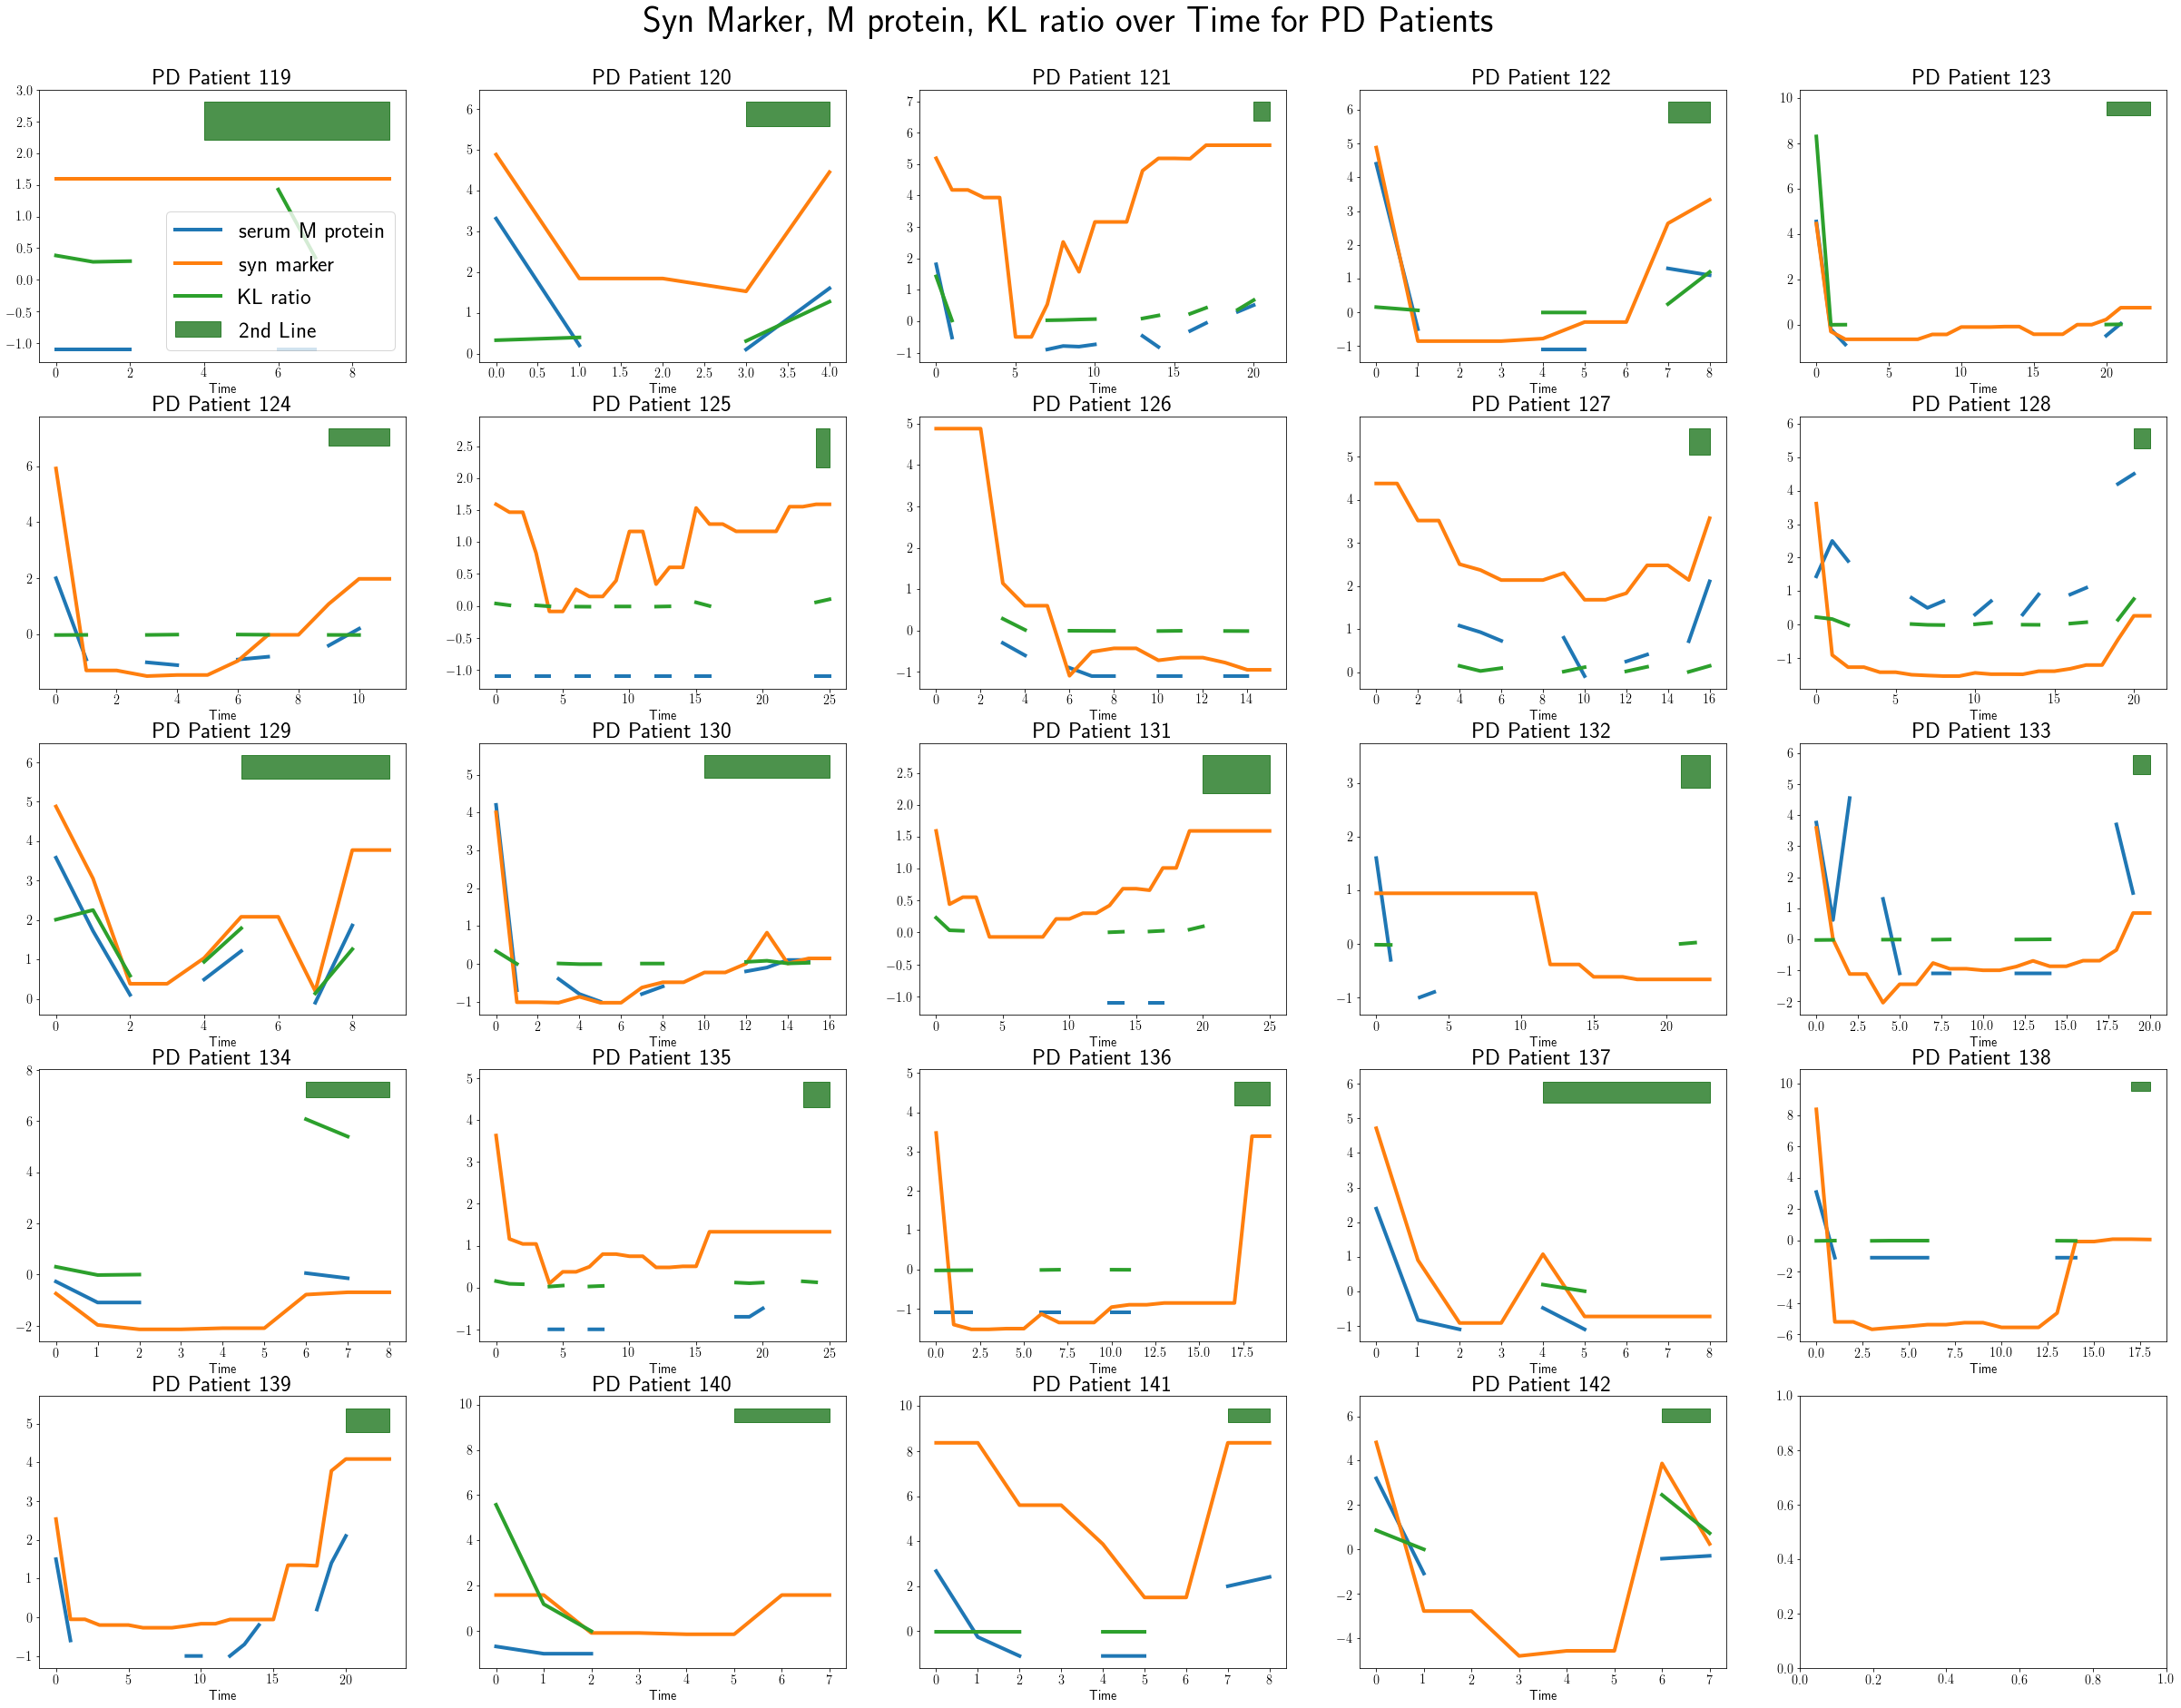

In [10]:
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(pd_idxs): 
    second_line = A[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, label='serum M protein')
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4, label='syn marker')
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,klidx], linewidth=4, label='KL ratio')
    ax[i].set_xlabel('Time')
    ymax = ax[i].get_ylim()[1]+0.05
    ys = np.array([ymax for x in range(len(sline_ts))])
    ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    ax[i].set_title(f'PD Patient {idx}', fontsize=25)
    if i == 0: 
        ax[i].legend(fontsize=25)
fig.suptitle('Syn Marker, M protein, KL ratio over Time for PD Patients', fontsize=40, y=0.92)
fig.savefig(f'restricted_feat_pds_klratio.pdf',bbox_inches='tight')

In [11]:
final_nonpd_idxs= nonpd_idxs[:25]
print(final_nonpd_idxs)

[ 50  55  71  11  54  30   7  69  97  85  91  47  26  28  63 113  36  16
  79  95  34  15   2  19  94]


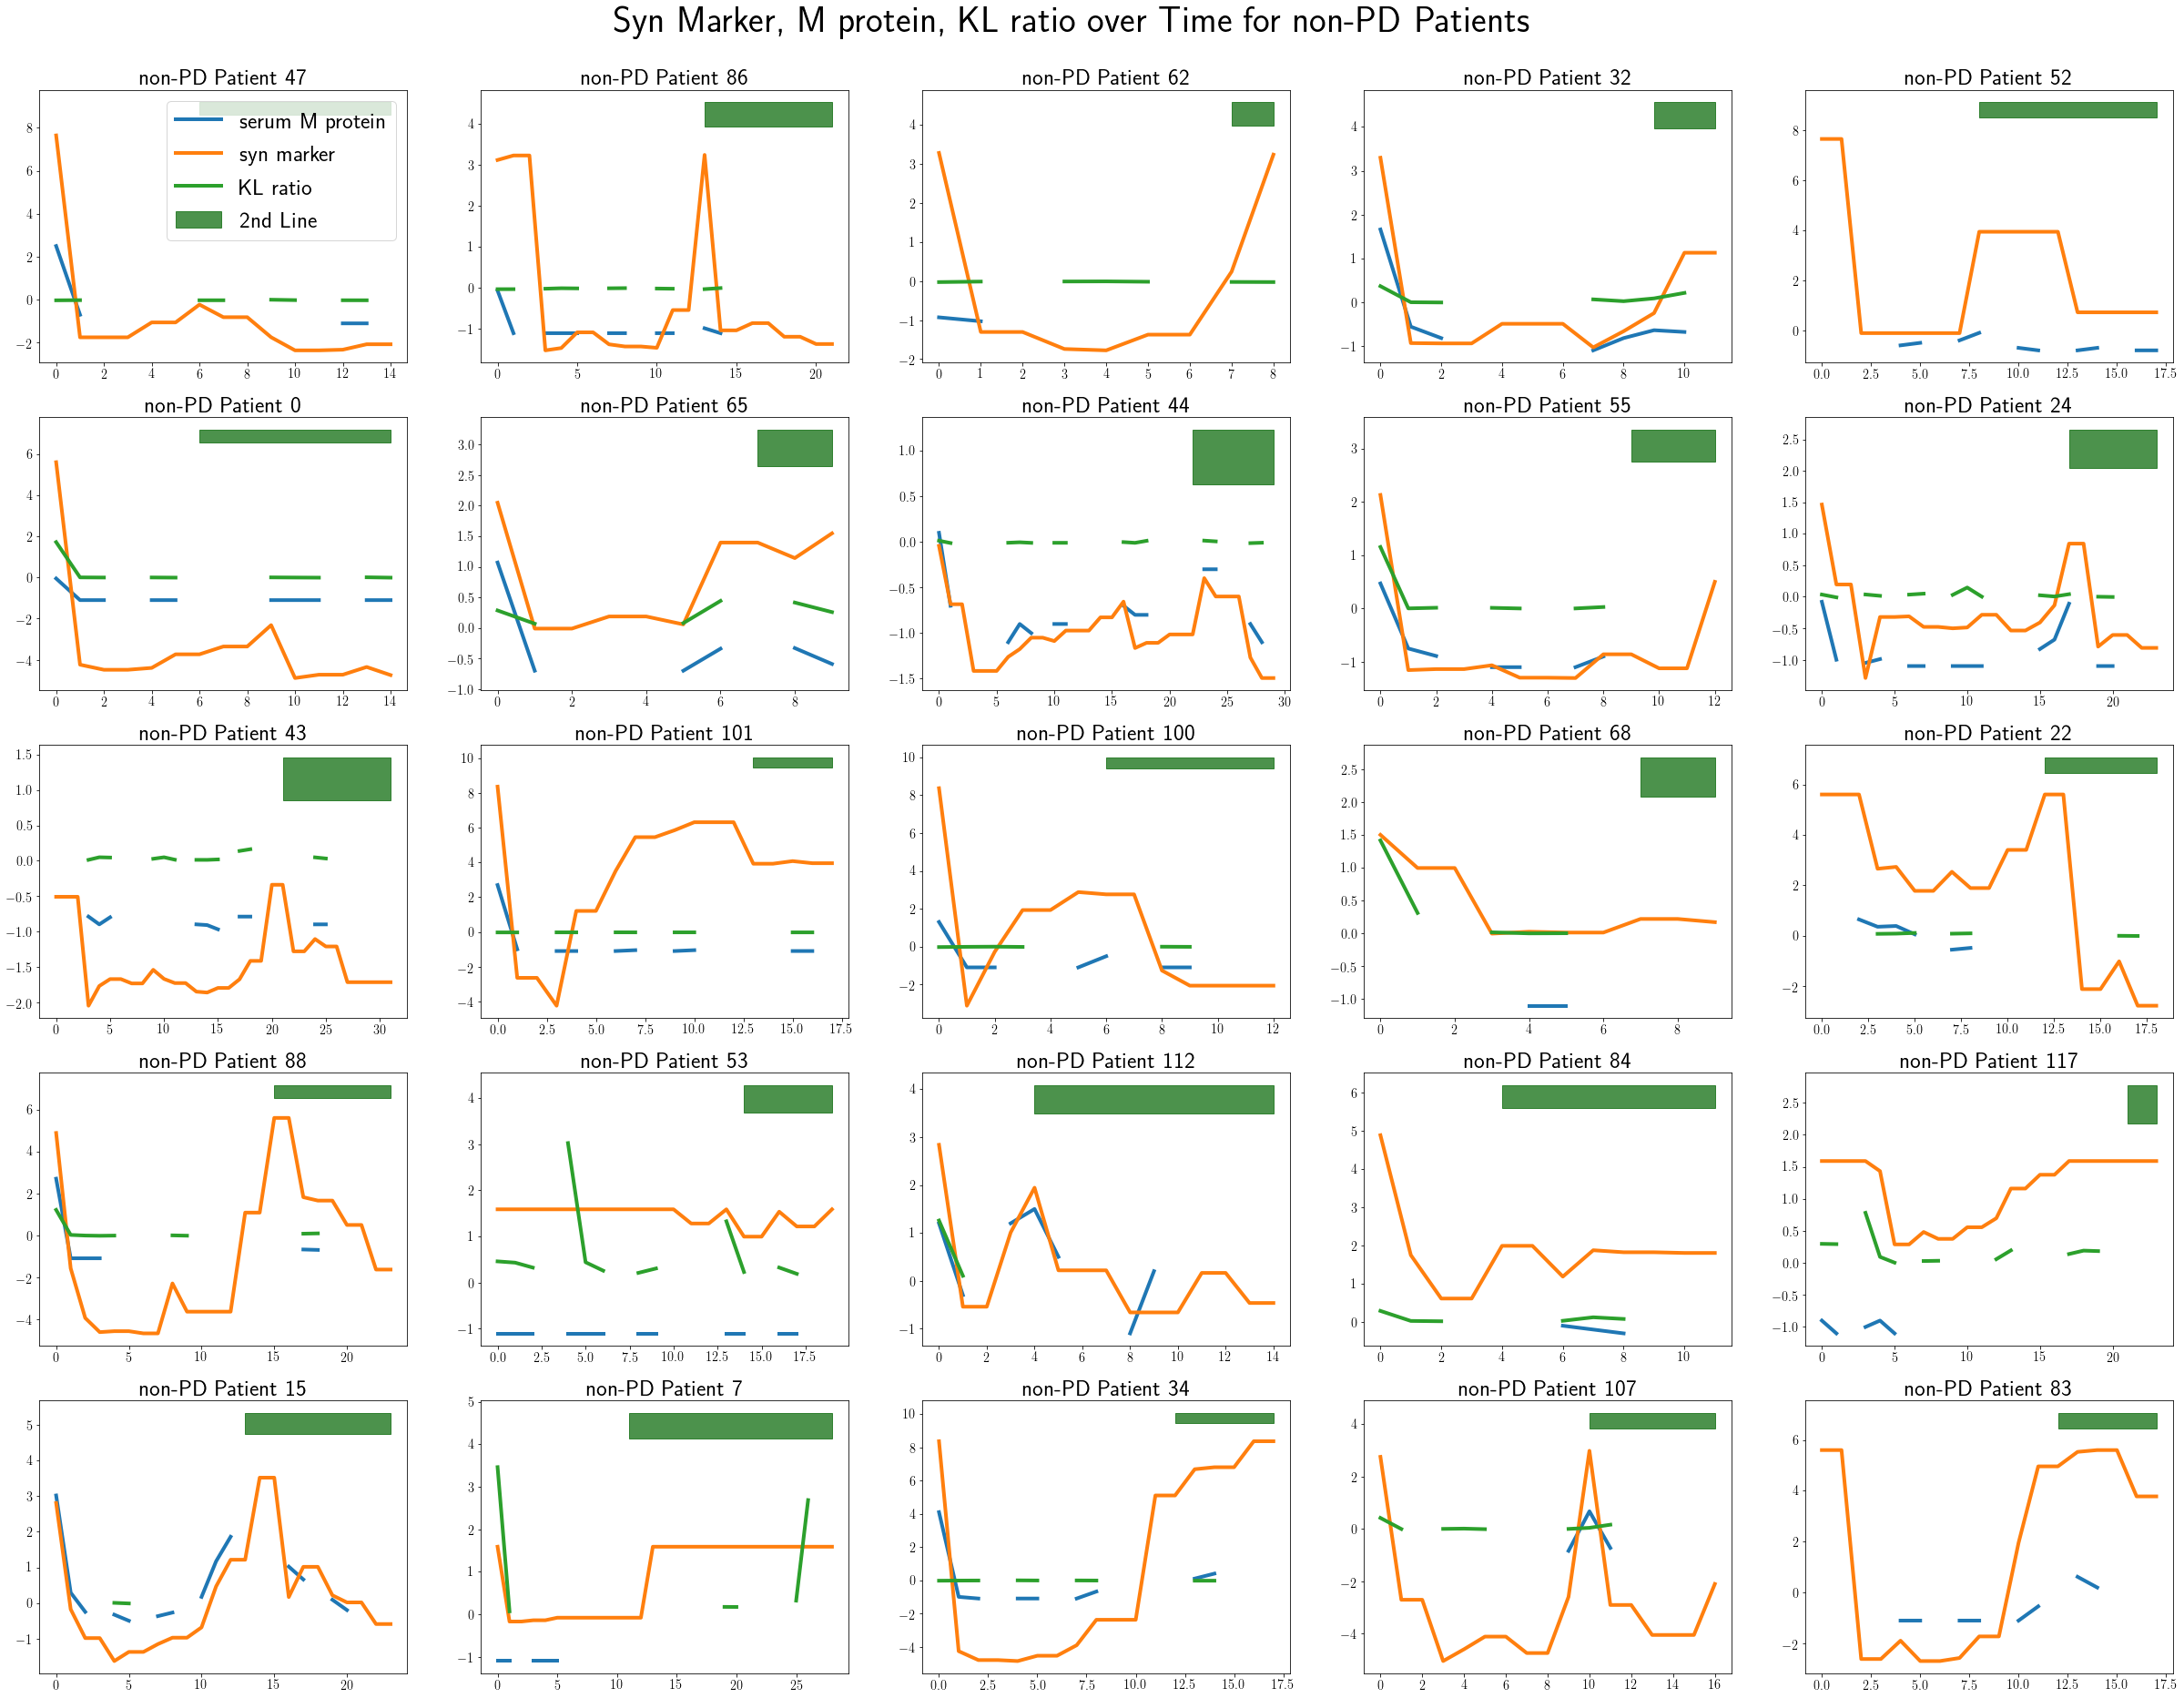

In [12]:
np.random.shuffle(nonpd_idxs)
fig, axlist = plt.subplots(5,5,figsize=(42,32))
ax         = axlist.ravel()
for i,idx in enumerate(final_nonpd_idxs): 
    second_line = A[idx,:,-2]
    sline_ts  = np.where(second_line == 1.)[0]
    if len(sline_ts) != 0: 
        sline_ts  = np.concatenate((sline_ts,[sline_ts[-1]+1]))
    orig_example = X[idx]
    orig_example[np.where(M[idx] == 0.)] = np.nan
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,midx], linewidth=4, label='serum M protein')
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,smidx], linewidth=4, label='syn marker')
    ax[i].plot(np.arange(orig_example.shape[0]), orig_example[:,klidx], linewidth=4, label='KL ratio')
    ymax = ax[i].get_ylim()[1]+0.05
    ys = np.array([ymax for x in range(len(sline_ts))])
    ax[i].fill_between(sline_ts, ys+0.4,ys+1., color='darkgreen', alpha=0.7, label='2nd Line')
    ax[i].set_title(f'non-PD Patient {idx}', fontsize=25)
    if i == 0: 
        ax[i].legend(fontsize=25)
fig.suptitle('Syn Marker, M protein, KL ratio over Time for non-PD Patients', fontsize=40, y=0.92)
fig.savefig(f'restricted_feat_nonpds_klratio.pdf',bbox_inches='tight')

In [56]:
# additive shifts 
def add_shift_tf(ddata,idx,typep='PD'): 
    fig, axlist = plt.subplots(11,1,figsize=(12,52))
    ax         = axlist.ravel()
    X = ddata[1]['train']['x'][[idx]]
    ax[0].plot(np.arange(X.shape[1]), X[0,:,0], linewidth=4)
    ax[0].plot(np.arange(X.shape[1]), X[0,:,1], linewidth=4)
    ax[0].set_title(f'original {typep} patient', fontsize=25)
    print(X)
    nsamples = 10*X.shape[0]
    Xnew     = np.zeros((nsamples,X.shape[1],X.shape[2]))
    for i in range(10):
        shift_factor = np.random.uniform(-4,4,size=X.shape[0])
        print(shift_factor)
        print(X+shift_factor)
        Xnew[i*X.shape[0]:(i+1)*X.shape[0]] = X+shift_factor
        
    for idx in range(Xnew.shape[0]): 
        orig_example = Xnew[idx]
        orig_example[np.where(M[idx] == 0.)] = np.nan
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,0], linewidth=4)
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,1], linewidth=4)
        ax[idx+1].set_title(f'{typep} patient {idx+1}', fontsize=25)
    return Xnew
        
# scaling in y direction
def scale_y_tf(ddata,idx,typep='PD'): 
    fig, axlist = plt.subplots(11,1,figsize=(12,52))
    ax         = axlist.ravel()
    X = ddata[1]['train']['x'][[idx]]
    ax[0].plot(np.arange(X.shape[1]), X[0,:,0], linewidth=4)
    ax[0].plot(np.arange(X.shape[1]), X[0,:,1], linewidth=4)
    ax[0].set_title(f'original {typep} patient', fontsize=25)
    print(X)
    nsamples = 10*X.shape[0]
    Xnew = np.zeros((nsamples,X.shape[1],X.shape[2]))
    for i in range(10): 
        scale_factor = np.random.uniform(1,3,size=X.shape[0])
        print(scale_factor)
#         print(X*scale_factor)
        Xnew[i*X.shape[0]:(i+1)*X.shape[0]] = X*scale_factor
    
    for idx in range(Xnew.shape[0]): 
        orig_example = Xnew[idx]
        orig_example[np.where(M[idx] == 0.)] = np.nan
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,0], linewidth=4)
        ax[idx+1].plot(np.arange(orig_example.shape[0]), orig_example[:,1], linewidth=4)
        ax[idx+1].set_title(f'{typep} patient {idx+1}', fontsize=25)
    return Xnew



[[[ 3.57999992  4.87899995]
  [ 1.71999991  3.05049992]
  [ 0.10000002  0.38125006]
  [ 0.10000002  0.38125006]
  [ 0.49000001  1.03374991]
  [ 1.20999992  2.07975012]
  [ 1.20999992  2.07975012]
  [-0.10000002  0.19575003]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]
  [ 1.86000001  3.77300024]]]
[2.85130569]
[1.83090009]
[1.55404922]
[2.7762327]
[2.1512585]
[1.54882943

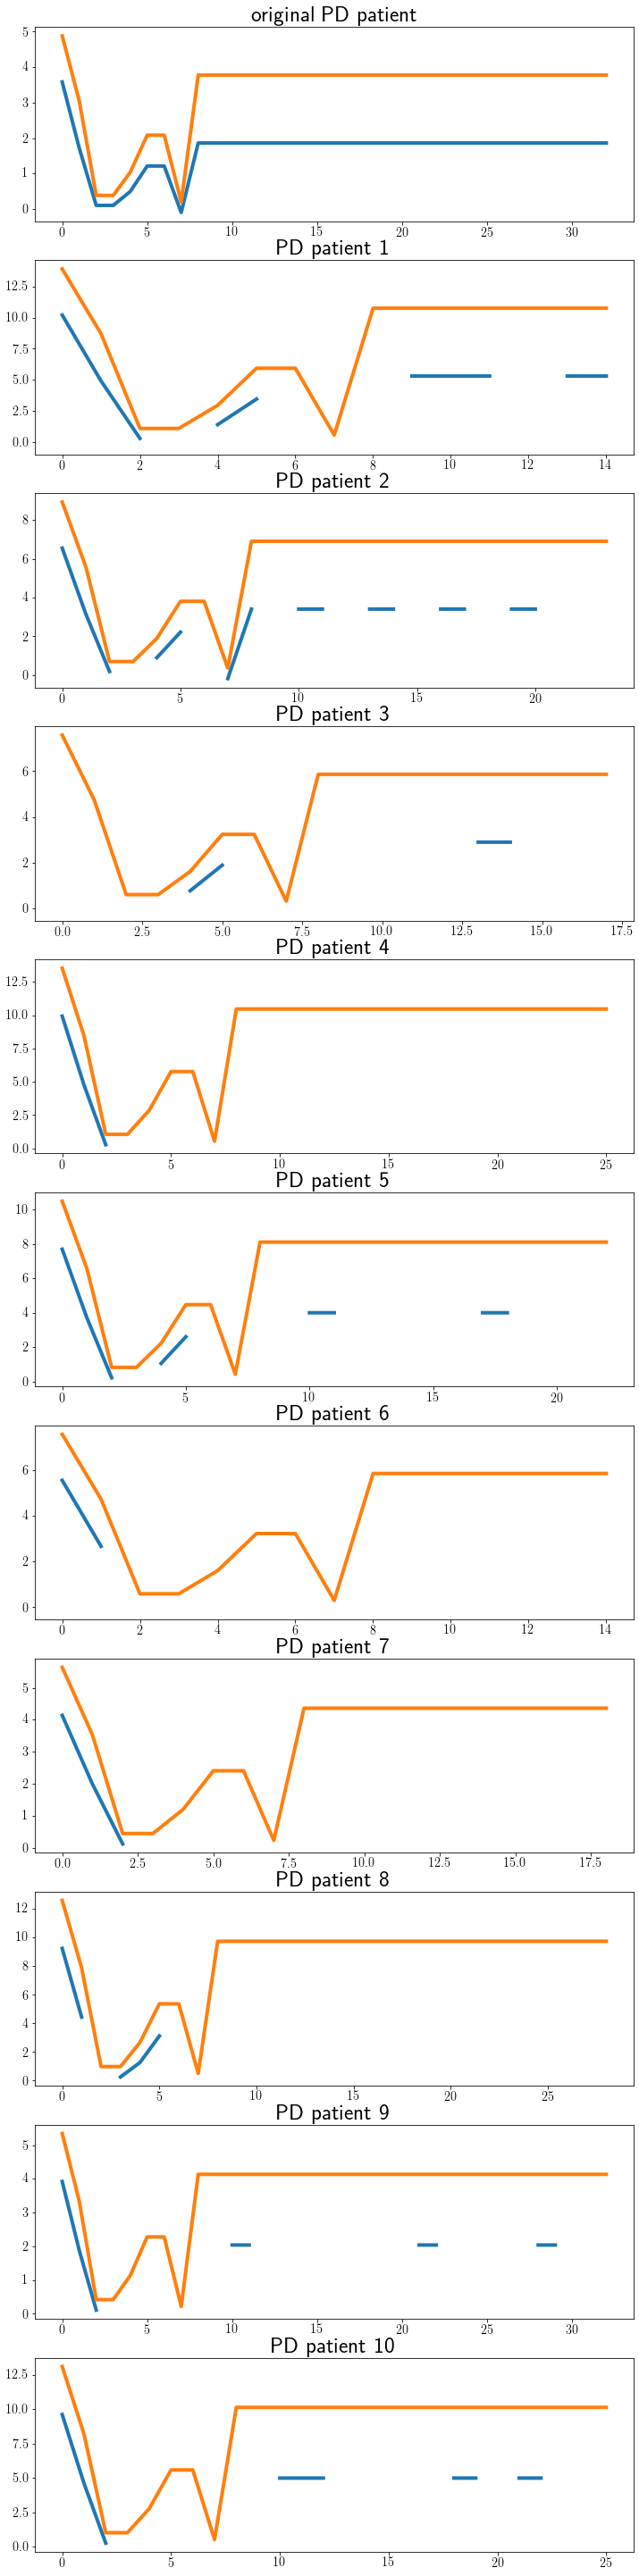

In [58]:
Xnew = scale_y_tf(ddata,pd_idxs[10],typep='PD')